# Regional-average SST-index Skill (correlation & RMSE)

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

# SMYLE Utility functions
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Start Dask Cluster

In [38]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks':True
    })
    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41520 instead
  warnings.warn(


In [7]:
cluster

# Data Intake

### Read in SMYLE monthly SST data using I/O functions; Convert to seasonal mean

In [8]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLONG','TAREA']].drop(['ULAT','ULONG'])
    d0 = d0.chunk({'L':-1})
    return d0

In [9]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 30.6 s, sys: 13.6 s, total: 44.2 s
Wall time: 1min 6s


11.563509676

In [10]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()

CPU times: user 14.6 s, sys: 290 ms, total: 14.9 s
Wall time: 16 s


In [11]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 1min 7s, sys: 14.5 s, total: 1min 21s
Wall time: 1min 41s


11.563509676

In [12]:
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()

In [13]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
#chunks={'z_t':1,'nlat':80}
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 1min 12s, sys: 14.6 s, total: 1min 27s
Wall time: 1min 48s


11.563509676

In [14]:
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()

In [15]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 1min 16s, sys: 14.6 s, total: 1min 31s
Wall time: 1min 51s


11.563509676

In [16]:
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()

# Compute Regional-average SST

### Define Averaging Regions

In [17]:
# lon-w, lon-e, lat-s, lat-n:
#region1lonlat = [-170.,-120.,-5.,5.]  
#region1title = 'Nino3.4'

region1lonlat = [-20.,0.,-3.,3.]  
region1title = 'Atlantic Nino'

region2lonlat = [-80.,-10.,10.,20.]  
region2title = 'Atlantic MDR'

region3lonlat = [50.,70.,-10.,10.]    # IOD-west, to be overwritten by IOD
region3title = 'Indian Ocean Dipole'

region4lonlat = [90.,110.,-10.,0.]  # IOD-east
region4title = 'IODe'

In [18]:
def POP_regional_areawgt(ds,lonlat):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [19]:
POPg16_reg1sst_area = POP_regional_areawgt(smyle11,region1lonlat)
POPg16_reg2sst_area = POP_regional_areawgt(smyle11,region2lonlat)
POPg16_reg3sst_area = POP_regional_areawgt(smyle11,region3lonlat)
POPg16_reg4sst_area = POP_regional_areawgt(smyle11,region4lonlat)

### Perform computation on SMYLE dask arrays, returning xarray:

In [20]:
%%time
smyle11_seas_time = smyle11_seas.time.load()
smyle02_seas_time = smyle02_seas.time.load()
smyle05_seas_time = smyle05_seas.time.load()
smyle08_seas_time = smyle08_seas.time.load()

CPU times: user 236 ms, sys: 7.64 ms, total: 243 ms
Wall time: 280 ms


In [21]:
%%time
smyle11_seas_reg1sst = smyle11_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg1sst = smyle02_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg1sst = smyle05_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg1sst = smyle08_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 52s, sys: 3.17 s, total: 2min 55s
Wall time: 3min 16s


In [22]:
%%time
smyle11_seas_reg2sst = smyle11_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg2sst = smyle02_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg2sst = smyle05_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg2sst = smyle08_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 28s, sys: 2.35 s, total: 2min 30s
Wall time: 2min 42s


In [23]:
%%time
smyle11_seas_reg3sst = smyle11_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg3sst = smyle02_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg3sst = smyle05_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg3sst = smyle08_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 54s, sys: 2.57 s, total: 2min 56s
Wall time: 3min 8s


In [24]:
%%time
smyle11_seas_reg4sst = smyle11_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg4sst = smyle02_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg4sst = smyle05_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg4sst = smyle08_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 49s, sys: 2.63 s, total: 2min 52s
Wall time: 3min 5s


In [25]:
%%time
smyle11_seas_reg3sst = smyle11_seas_reg3sst - smyle11_seas_reg4sst
smyle02_seas_reg3sst = smyle02_seas_reg3sst - smyle02_seas_reg4sst
smyle05_seas_reg3sst = smyle05_seas_reg3sst - smyle05_seas_reg4sst
smyle08_seas_reg3sst = smyle08_seas_reg3sst - smyle08_seas_reg4sst

CPU times: user 2.34 ms, sys: 949 µs, total: 3.29 ms
Wall time: 3.3 ms


### Remove leadtime-dependent drift from SMYLE data:

In [26]:
%%time
climy0 = 1972
climy1 = 2018
smyle11_reg1sst_dd,smyle11_reg1sst_drift = stat.remove_drift(smyle11_seas_reg1sst,smyle11_seas_time,climy0,climy1)
smyle02_reg1sst_dd,smyle02_reg1sst_drift = stat.remove_drift(smyle02_seas_reg1sst,smyle02_seas_time,climy0,climy1)
smyle05_reg1sst_dd,smyle05_reg1sst_drift = stat.remove_drift(smyle05_seas_reg1sst,smyle05_seas_time,climy0,climy1)
smyle08_reg1sst_dd,smyle08_reg1sst_drift = stat.remove_drift(smyle08_seas_reg1sst,smyle08_seas_time,climy0,climy1)

smyle11_reg2sst_dd,smyle11_reg2sst_drift = stat.remove_drift(smyle11_seas_reg2sst,smyle11_seas_time,climy0,climy1)
smyle02_reg2sst_dd,smyle02_reg2sst_drift = stat.remove_drift(smyle02_seas_reg2sst,smyle02_seas_time,climy0,climy1)
smyle05_reg2sst_dd,smyle05_reg2sst_drift = stat.remove_drift(smyle05_seas_reg2sst,smyle05_seas_time,climy0,climy1)
smyle08_reg2sst_dd,smyle08_reg2sst_drift = stat.remove_drift(smyle08_seas_reg2sst,smyle08_seas_time,climy0,climy1)

smyle11_reg3sst_dd,smyle11_reg3sst_drift = stat.remove_drift(smyle11_seas_reg3sst,smyle11_seas_time,climy0,climy1)
smyle02_reg3sst_dd,smyle02_reg3sst_drift = stat.remove_drift(smyle02_seas_reg3sst,smyle02_seas_time,climy0,climy1)
smyle05_reg3sst_dd,smyle05_reg3sst_drift = stat.remove_drift(smyle05_seas_reg3sst,smyle05_seas_time,climy0,climy1)
smyle08_reg3sst_dd,smyle08_reg3sst_drift = stat.remove_drift(smyle08_seas_reg3sst,smyle08_seas_time,climy0,climy1)

CPU times: user 72 ms, sys: 1.09 ms, total: 73 ms
Wall time: 124 ms


### Compute observed seasonal anomalies:

In [27]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and replace 'time' with 'year,season' dimensions."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [28]:
# Observed SST Index (NOAA ERSSTv5)
ds_obs = xr.open_dataset('/glade/campaign/cesm/development/espwg/verification_datasets/mon/SST/ersst.v5.188001-202012.nc',decode_times=False)
obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_obs['time'] = obs_time_vals

In [29]:
# Region 1
tmp = ds_obs.sst.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg1sst_seas = obs_convert_mon_to_seas(obs_regsst,'sst')
obs_reg1sst_seas = obs_reg1sst_seas - obs_reg1sst_seas.sel(year=slice(climy0,climy1)).mean('year')

In [30]:
# Region 2
tmp = ds_obs.sst.sel(lat=slice(region2lonlat[2],region2lonlat[3])).sel(lon=slice(360+region2lonlat[0],360+region2lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg2sst_seas = obs_convert_mon_to_seas(obs_regsst,'sst')
obs_reg2sst_seas = obs_reg2sst_seas - obs_reg2sst_seas.sel(year=slice(climy0,climy1)).mean('year')

In [31]:
# Region 3
tmp = ds_obs.sst.sel(lat=slice(region3lonlat[2],region3lonlat[3])).sel(lon=slice(region3lonlat[0],region3lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg3sst_seas = obs_convert_mon_to_seas(obs_regsst,'sst')

tmp = ds_obs.sst.sel(lat=slice(region4lonlat[2],region4lonlat[3])).sel(lon=slice(region4lonlat[0],region4lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg4sst_seas = obs_convert_mon_to_seas(obs_regsst,'sst')

obs_reg3sst_seas = obs_reg3sst_seas - obs_reg4sst_seas
obs_reg3sst_seas = obs_reg3sst_seas - obs_reg3sst_seas.sel(year=slice(climy0,climy1)).mean('year')

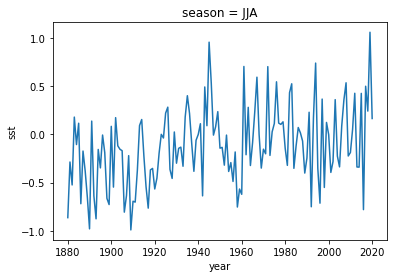

In [32]:
obs_reg3sst_seas.sst.isel(season=2).plot();

# Plots

### Generate ACC and normalized RMSE Skill Plot

In [33]:
%%time
# Correlation as a function of forecast lead month:
smyle11_skill_reg1 = stat.leadtime_skill_seas(smyle11_reg1sst_dd,smyle11_seas_time,obs_reg1sst_seas.sst,detrend=True)
smyle02_skill_reg1 = stat.leadtime_skill_seas(smyle02_reg1sst_dd,smyle02_seas_time,obs_reg1sst_seas.sst,detrend=True)
smyle05_skill_reg1 = stat.leadtime_skill_seas(smyle05_reg1sst_dd,smyle05_seas_time,obs_reg1sst_seas.sst,detrend=True)
smyle08_skill_reg1 = stat.leadtime_skill_seas(smyle08_reg1sst_dd,smyle08_seas_time,obs_reg1sst_seas.sst,detrend=True)

smyle11_skill_reg2 = stat.leadtime_skill_seas(smyle11_reg2sst_dd,smyle11_seas_time,obs_reg2sst_seas.sst,detrend=True)
smyle02_skill_reg2 = stat.leadtime_skill_seas(smyle02_reg2sst_dd,smyle02_seas_time,obs_reg2sst_seas.sst,detrend=True)
smyle05_skill_reg2 = stat.leadtime_skill_seas(smyle05_reg2sst_dd,smyle05_seas_time,obs_reg2sst_seas.sst,detrend=True)
smyle08_skill_reg2 = stat.leadtime_skill_seas(smyle08_reg2sst_dd,smyle08_seas_time,obs_reg2sst_seas.sst,detrend=True)

smyle11_skill_reg3 = stat.leadtime_skill_seas(smyle11_reg3sst_dd,smyle11_seas_time,obs_reg3sst_seas.sst,detrend=True)
smyle02_skill_reg3 = stat.leadtime_skill_seas(smyle02_reg3sst_dd,smyle02_seas_time,obs_reg3sst_seas.sst,detrend=True)
smyle05_skill_reg3 = stat.leadtime_skill_seas(smyle05_reg3sst_dd,smyle05_seas_time,obs_reg3sst_seas.sst,detrend=True)
smyle08_skill_reg3 = stat.leadtime_skill_seas(smyle08_reg3sst_dd,smyle08_seas_time,obs_reg3sst_seas.sst,detrend=True)


CPU times: user 2.75 s, sys: 36.6 ms, total: 2.78 s
Wall time: 3.24 s


In [34]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
region = xr.DataArray([1,2,3],name='region',dims='region')
reg1_skill = xr.concat([smyle11_skill_reg1,smyle02_skill_reg1,smyle05_skill_reg1,smyle08_skill_reg1],dim=startmonth)
reg2_skill = xr.concat([smyle11_skill_reg2,smyle02_skill_reg2,smyle05_skill_reg2,smyle08_skill_reg2],dim=startmonth)
reg3_skill = xr.concat([smyle11_skill_reg3,smyle02_skill_reg3,smyle05_skill_reg3,smyle08_skill_reg3],dim=startmonth)
reg_skill = xr.concat([reg1_skill,reg2_skill,reg3_skill],dim=region)
regiontitle = xr.DataArray([region1title,region2title,region3title],name='regiontitle',dims='region')
reg_skill['regiontitle'] = regiontitle

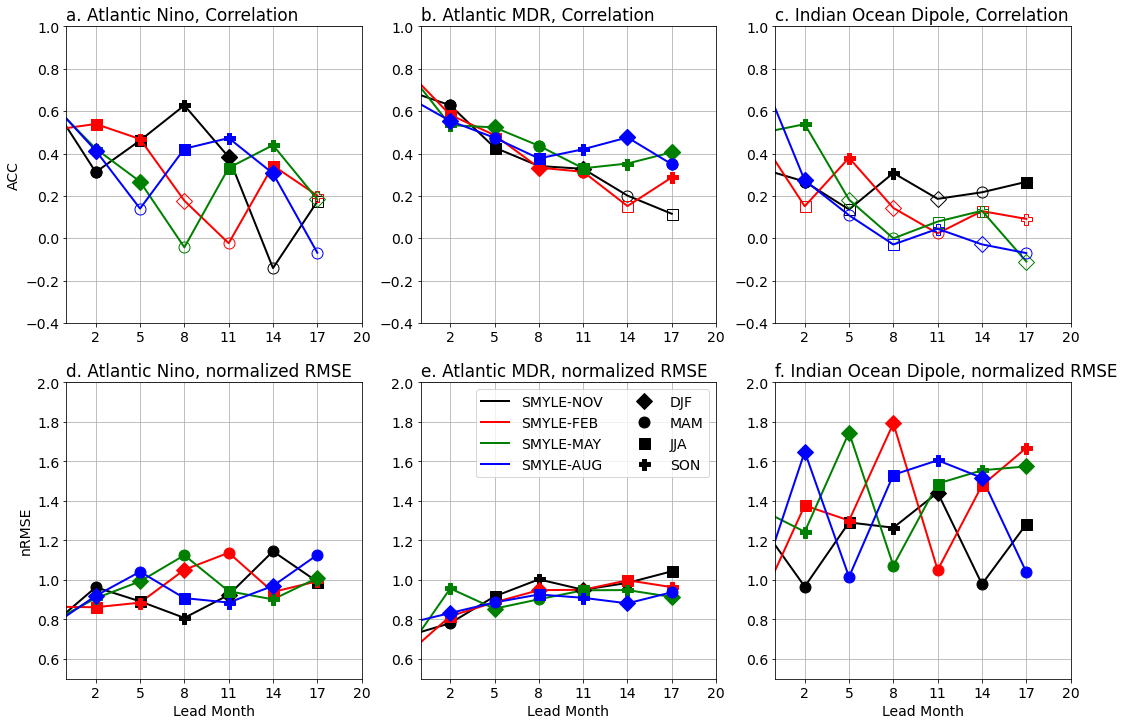

In [36]:
# plot skill scores
fig = plt.figure(figsize=(18,12))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_reg1.L-2
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
colors = ['k','r','g','b']
hindcasts = ['NOV','FEB','MAY','AUG']
figlabs = [['a.','b.','c.'],['d.','e.','f.']]

ncol = 3
nrow = 2

for i in range(ncol):
    ax = fig.add_subplot(nrow,ncol,i+1)
    if i==0: ax.set_ylabel('ACC', fontsize=14)
    ax.set_title(figlabs[0][i]+' {}, Correlation'.format(reg_skill.isel(region=i).regiontitle.values),loc='left')
    for j in range(4):
        ax.plot(leadmon,reg_skill.isel(region=i,startmonth=j).corr,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
        for k,l in zip(seasons,markers):
            tmp = reg_skill.isel(region=i,startmonth=j)
            ax.plot(leadmon,tmp.corr.where(tmp.season==k),color=colors[j],marker=l,markersize=11,fillstyle='none')
            ax.plot(leadmon,tmp.corr.where(tmp.season==k).where(tmp.pval<0.1),color=colors[j],marker=l,markersize=11)
            
    ax.set_xticks(leadmon)
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([-0.4,1])
        
    ax = fig.add_subplot(nrow,ncol,i+4)
    if i==0: ax.set_ylabel(r'nRMSE', fontsize=14)
    ax.set_title(figlabs[1][i]+' {}, normalized RMSE'.format(reg_skill.isel(region=i).regiontitle.values),loc='left')
    for j in range(4):
        ax.plot(leadmon,reg_skill.isel(region=i,startmonth=j).nrmse,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
    for j in range(4):
        for k,l in zip(seasons,markers):
            tmp = reg_skill.isel(region=i,startmonth=j)
            if j==0: ax.plot(leadmon,tmp.nrmse.where(tmp.season==k),color=colors[j],marker=l,label=k,markersize=11,linestyle='None')
            if j!=0: ax.plot(leadmon,tmp.nrmse.where(tmp.season==k),color=colors[j],marker=l,markersize=11)
    if i==1: leg1 = ax.legend(loc='upper right',ncol=2)
    ax.set_xticks(leadmon)
    ax.set_xlabel('Lead Month')
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([0.5,2])
    
plt.savefig('Fig05_regionalSST_skill.png')